# **EMOTION DETECTION**

In [1]:
import pandas as pd
import numpy as np
import os
import string
import nltk
import re
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
%%capture
from transformers import BertForMaskedLM, Trainer, TrainingArguments
# from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score



2025-06-17 17:35:30.891801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750181731.134019      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750181731.201957      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv("/kaggle/input/indonesian-emotion-classificatio/emotion.csv" )

## **EXPLORATORY DATA ANALYST**

In [5]:
df.head()

,text,label
0,pagi2 udah di buat emosi :),Anger
1,"kok stabilitas negara, memange 10 thn negara t...",Anger
2,dah lah emosi mulu liat emyu,Anger
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger
4,dih lu yg nyebelin bego,Anger


In [6]:
df.tail()

,text,label
7075,pagi saat seisi semesta sujud pada zat yg acap...,Sad
7076,"meski engkau yg pergi, meski engkau yg meningg...",Sad
7077,udah biasa kalah dan tersakiti,Sad
7078,"apakabar ku?. apakah baik-baik saja,, tidak, a...",Sad
7079,this user sdg tidak.baik.baik saja sdg stress,Sad


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7080 non-null   object
 1   label   7080 non-null   object
dtypes: object(2)
memory usage: 110.8+ KB


In [8]:
df.describe()

,text,label
count,7080,7080
unique,7018,6
top,sedih,Neutral
freq,5,2001


In [9]:
df['label'].unique()

array(['Anger', 'Joy', 'Fear', 'Love', 'Neutral', 'Sad'], dtype=object)

In [10]:
df = df[df['label'].isin(['Anger', 'Joy','Fear', 'Neutral', 'Love', 'Sad' ])]

In [11]:
df.value_counts('label')

label
Neutral    2001
Joy        1275
Anger      1130
Sad        1003
Fear        911
Love        760
Name: count, dtype: int64

<Axes: title={'center': 'words_per_text'}, xlabel='label'>

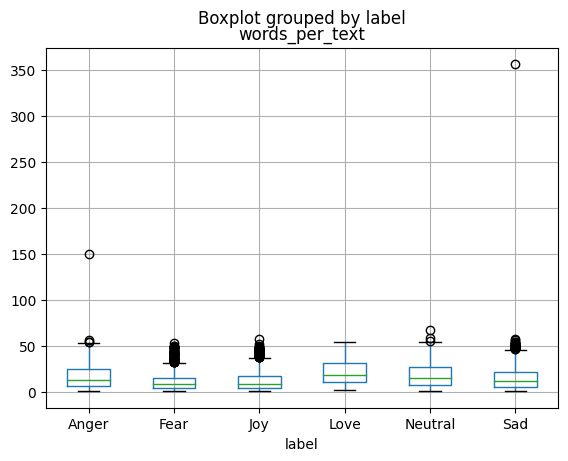

In [12]:
df['words_per_text'] = df['text'].str.split().apply(len)
df.boxplot('words_per_text', by='label')

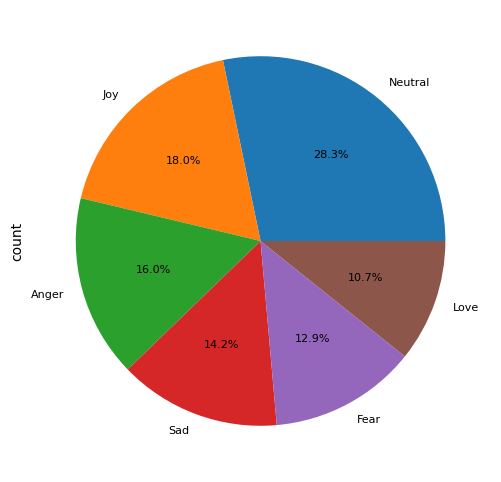

In [13]:
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=8)
plt.show()

/tmp/ipykernel_35/955195299.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(label_counts))


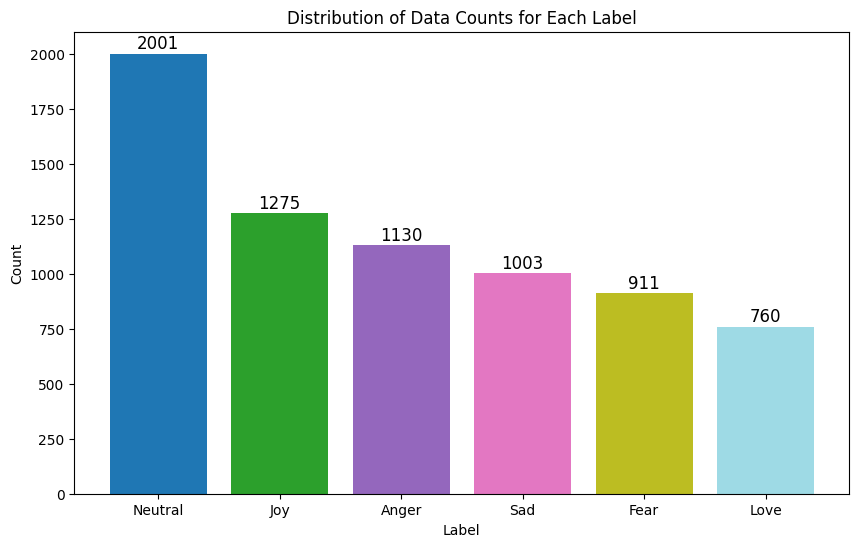

In [14]:
label_counts = df['label'].value_counts()
colors = plt.cm.get_cmap('tab20', len(label_counts))
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors(range(len(label_counts))))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=12)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Data Counts for Each Label')
plt.show()


## **PREPROCESSING**

In [15]:
df

,text,label,words_per_text
0,pagi2 udah di buat emosi :),Anger,6
1,"kok stabilitas negara, memange 10 thn negara t...",Anger,25
2,dah lah emosi mulu liat emyu,Anger,6
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger,40
4,dih lu yg nyebelin bego,Anger,5
...,...,...,...
7075,pagi saat seisi semesta sujud pada zat yg acap...,Sad,47
7076,"meski engkau yg pergi, meski engkau yg meningg...",Sad,44
7077,udah biasa kalah dan tersakiti,Sad,5
7078,"apakabar ku?. apakah baik-baik saja,, tidak, a...",Sad,14


In [16]:
df[df["label"]=='Anger']

,text,label,words_per_text
0,pagi2 udah di buat emosi :),Anger,6
1,"kok stabilitas negara, memange 10 thn negara t...",Anger,25
2,dah lah emosi mulu liat emyu,Anger,6
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger,40
4,dih lu yg nyebelin bego,Anger,5
...,...,...,...
1125,dan yg emng belom tau banyak lah tentang dunia...,Anger,49
1126,"aa kesel bgt anying. dia sudah di bandaraa, gi...",Anger,37
1127,"ini segala keresahan gua udah mau ilang nihh, ...",Anger,45
1128,"gue pernah datang lebih awal, sebelum waktu ny...",Anger,34


In [17]:
df[df["label"]=='Joy']

,text,label,words_per_text
1130,dipeluk enak nih,Joy,3
1131,masih dongg wkkwkwtar klo gk semangat gk bisa ...,Joy,11
1132,semangat dan bertambah kuatlah kalian frp_nats...,Joy,9
1133,jangan lupa sarapann semangat buat hari inii a...,Joy,12
1134,aw ikut seneng semangat ya kuliahnya!,Joy,6
...,...,...,...
2400,yaaaa rumah sepi. mari kita party wakwakk,Joy,7
2401,"seru tau prenjon zer kdng sedih kdng baper, se...",Joy,10
2402,aahh iyaa bgtt hazaa!! kek tbtb bawaannya mell...,Joy,20
2403,kadrun kroco sih cuman dapet nasbung jk ada or...,Joy,23


In [18]:
df[df["label"]=='Fear']

,text,label,words_per_text
2405,trs barusan dia reach out aku trs minta tolong...,Fear,22
2406,sumpah ini receh bgt dan not bts related. cm j...,Fear,48
2407,ragu utk bisa beli barang tu karn harganya bis...,Fear,12
2408,bisa gak sih langsung tanggal 11 aja gausah ad...,Fear,18
2409,iya kaan yg lain suka pada coba pd gpp tp tete...,Fear,13
...,...,...,...
3311,bgt! sepi dan serem,Fear,4
3312,sepi aneh kayak ada yg perhatiin tapi gk ada s...,Fear,10
3313,joonyoung.. paling merinding sama sedih jadi 1,Fear,7
3314,"mau nonton kukira kau rumah awokaowkwk, tapi t...",Fear,12


In [19]:
df[df["label"]=='Neutral']

,text,label,words_per_text
4076,pengabdian yang terpuji meskipun terlihat biasa,Neutral,6
4077,baru saja mengirim foto,Neutral,4
4078,apa kabar dunia twitter ? masihkah selucu dan ...,Neutral,11
4079,yah gimana sih yang yaudah susul aku dulu kita...,Neutral,14
4080,saja ka dorg suro beli medium 2 set,Neutral,8
...,...,...,...
6072,"karena tau rasa kesepian, manusia akan menjadi...",Neutral,19
6073,yang terbaik adalah percaya dan berlindung han...,Neutral,21
6074,sahabat adalah mereka yg tahu bahwa ada sedih ...,Neutral,18
6075,"terkadang, bukan karena dusta, kamu membenci s...",Neutral,19


In [20]:
df[df["label"]=='Love']

,text,label,words_per_text
3316,"suka banget kata2, ""kebenaran hanya menurut se...",Love,9
3317,hanse mode anak rumahan gini tuh aku suka bang...,Love,36
3318,"ya kali ngejar ngejar cinta, ngejar tahajjud a...",Love,11
3319,selamat pagi sender! sana avail nih pas hari v...,Love,39
3320,sopaa!! cuz akuu suka banget jurusan tari di s...,Love,27
...,...,...,...
4071,ngeliat teaser wonpil jadi sedih anjir apaan s...,Love,11
4072,"lae ku sayang jangan sedih ya, bentar lagu kau...",Love,20
4073,"lockey tetep harus support secret number juga,...",Love,41
4074,"ku tetap membelamu meski kau jahat, karna ku c...",Love,10


In [21]:
df[df["label"]=='Sad']

,text,label,words_per_text
6077,"akibat dari telat bangun, anak ikut bangun dan...",Sad,32
6078,sepi,Sad,1
6079,sedih dah,Sad,2
6080,"sedih emg kalo ditinggal temen ngebucin, sedih...",Sad,18
6081,sedih bener niih club ya,Sad,5
...,...,...,...
7075,pagi saat seisi semesta sujud pada zat yg acap...,Sad,47
7076,"meski engkau yg pergi, meski engkau yg meningg...",Sad,44
7077,udah biasa kalah dan tersakiti,Sad,5
7078,"apakabar ku?. apakah baik-baik saja,, tidak, a...",Sad,14


In [22]:
df['length'] = df['text'].apply(lambda x: len(x))

In [23]:
df[df['length']<1]

,text,label,words_per_text,length


In [24]:
df = df[df['length']>1]
df = df.reset_index(drop=True)

In [25]:
df[df.duplicated()].sort_values(by=['text'])
df.head(3000)

,text,label,words_per_text,length
0,pagi2 udah di buat emosi :),Anger,6,27
1,"kok stabilitas negara, memange 10 thn negara t...",Anger,25,184
2,dah lah emosi mulu liat emyu,Anger,6,28
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger,40,277
4,dih lu yg nyebelin bego,Anger,5,23
...,...,...,...,...
2995,"plis jgn liat rep gue dulu malu, untung dah di...",Fear,11,51
2996,gw sih malu..klo digituin,Fear,4,25
2997,yakin ilangin mie ayam? ko aku ragu?,Fear,7,36
2998,"wordle 234 3/6 kaget sendiri, bisa-bisanya teb...",Fear,10,73


In [26]:
df[df.duplicated()]

,text,label,words_per_text,length
381,bangsat,Anger,1,7
759,dih tolol,Anger,2,9
929,ya kalo mau poligami ikuti sunah rosul tunggu ...,Anger,30,163
1101,"pagi pagi udah emosi baca au kesel, gak blh ad...",Anger,17,82
1106,kecewa w bangsat,Anger,3,16
1107,aq dh 5 kali approach..smua ke reject..sedih s...,Anger,40,245
1109,"baru mau sedih kenapa close, endingnya bikin e...",Anger,13,78
1185,semangat buat hari ini!,Joy,4,23
1303,semangat pagi,Joy,2,13
1374,semangat,Joy,1,8


In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df.tail()

,text,label,words_per_text,length
7023,pagi saat seisi semesta sujud pada zat yg acap...,Sad,47,267
7024,"meski engkau yg pergi, meski engkau yg meningg...",Sad,44,263
7025,udah biasa kalah dan tersakiti,Sad,5,30
7026,"apakabar ku?. apakah baik-baik saja,, tidak, a...",Sad,14,95
7027,this user sdg tidak.baik.baik saja sdg stress,Sad,7,45


In [29]:
temp = df.groupby('label').count()['text'].reset_index()
temp.style.background_gradient(cmap='Blues')

,label,text
0,Anger,1123
1,Fear,906
2,Joy,1258
3,Love,754
4,Neutral,1992
5,Sad,995


In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [31]:
df['label'] = label_encoder.fit_transform(df['label'])

In [32]:
label_encoder.classes_

array(['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad'], dtype=object)

In [33]:
df[df['label']==0]

,text,label,words_per_text,length
0,pagi2 udah di buat emosi :),0,6,27
1,"kok stabilitas negara, memange 10 thn negara t...",0,25,184
2,dah lah emosi mulu liat emyu,0,6,28
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0,40,277
4,dih lu yg nyebelin bego,0,5,23
...,...,...,...,...
1118,dan yg emng belom tau banyak lah tentang dunia...,0,49,273
1119,"aa kesel bgt anying. dia sudah di bandaraa, gi...",0,37,199
1120,"ini segala keresahan gua udah mau ilang nihh, ...",0,45,254
1121,"gue pernah datang lebih awal, sebelum waktu ny...",0,34,201


In [34]:
df.head(3000)

,text,label,words_per_text,length
0,pagi2 udah di buat emosi :),0,6,27
1,"kok stabilitas negara, memange 10 thn negara t...",0,25,184
2,dah lah emosi mulu liat emyu,0,6,28
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0,40,277
4,dih lu yg nyebelin bego,0,5,23
...,...,...,...,...
2995,"faktanya gua bahagia kenal dia, gua bahagia ke...",1,35,217
2996,kenapa acc gede moa banyak yg rest moga cepet ...,1,19,105
2997,takut sm sembi,1,3,14
2998,alhamdulillah drawnya agak wangi tapi tetep takut,1,7,49


In [35]:
data = df.copy()
data.head(3000)

,text,label,words_per_text,length
0,pagi2 udah di buat emosi :),0,6,27
1,"kok stabilitas negara, memange 10 thn negara t...",0,25,184
2,dah lah emosi mulu liat emyu,0,6,28
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0,40,277
4,dih lu yg nyebelin bego,0,5,23
...,...,...,...,...
2995,"faktanya gua bahagia kenal dia, gua bahagia ke...",1,35,217
2996,kenapa acc gede moa banyak yg rest moga cepet ...,1,19,105
2997,takut sm sembi,1,3,14
2998,alhamdulillah drawnya agak wangi tapi tetep takut,1,7,49


In [36]:
data.drop(columns=['words_per_text','length'], inplace=True)
data.head(3000)

,text,label
0,pagi2 udah di buat emosi :),0
1,"kok stabilitas negara, memange 10 thn negara t...",0
2,dah lah emosi mulu liat emyu,0
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0
4,dih lu yg nyebelin bego,0
...,...,...
2995,"faktanya gua bahagia kenal dia, gua bahagia ke...",1
2996,kenapa acc gede moa banyak yg rest moga cepet ...,1
2997,takut sm sembi,1
2998,alhamdulillah drawnya agak wangi tapi tetep takut,1


In [37]:
data.shape

(7028, 2)

In [38]:
data = data.reset_index(drop=True)

In [39]:
data["label"].unique()

array([0, 2, 1, 3, 4, 5])

In [40]:
# label_encoder.inverse_transform([5])

In [41]:
# data['label'] = data['label'].replace({0: 'Anger', 1: 'Fear', 2: 'Joy', 3: 'Love', 4: 'Neutral', 5: 'Sad'})

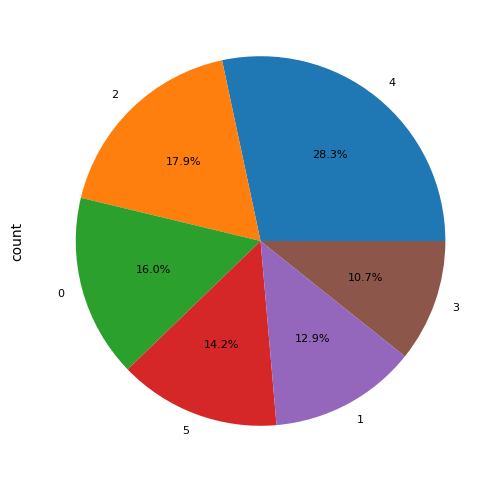

In [42]:
plt.figure(figsize=(10, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=8)
plt.show()

In [43]:
df = data.copy()
df.head()

,text,label
0,pagi2 udah di buat emosi :),0
1,"kok stabilitas negara, memange 10 thn negara t...",0
2,dah lah emosi mulu liat emyu,0
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0
4,dih lu yg nyebelin bego,0


### Lowercase

**NOTE: UNTUK MODEL CASE TIDAK PERLU MELAKUKAN LOWERCASE, SEDANGKAN UNTUK MODEL UNCASED, PERLU MELAKUKAN LOWERCASE**

In [44]:
# def lowercase_text(df, column_name):
#     df[column_name] = df[column_name].str.lower()
#     return df

# df = lowercase_text(df, 'text')
# df = lowercase_text(df, 'label')
# df.head(10)

### Remove Extra WhiteSpace

In [45]:
def remove_extra_whitespace(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()))
    return df
df = remove_extra_whitespace(df, 'text')


### Remove user handles

In [46]:
!pip install NeatText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.3 MB/s eta 0:00:00


In [47]:
import neattext.functions as nfx

df['text'].apply(nfx.remove_userhandles)

0                             pagi2 udah di buat emosi :)
1       kok stabilitas negara, memange 10 thn negara t...
2                            dah lah emosi mulu liat emyu
3       aib? bodoh benar! sebelum kata aib itu muncul,...
4                                 dih lu yg nyebelin bego
                              ...                        
7023    pagi saat seisi semesta sujud pada zat yg acap...
7024    meski engkau yg pergi, meski engkau yg meningg...
7025                       udah biasa kalah dan tersakiti
7026    apakabar ku?. apakah baik-baik saja,, tidak, a...
7027        this user sdg tidak.baik.baik saja sdg stress
Name: text, Length: 7028, dtype: object

In [48]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [49]:
df.tail(10)

,text,label
7018,"aku sangat bodoh, saat aku tahu aku jatuh cint...",5
7019,"iya, tentu saja ada airmata, tentu saja ada se...",5
7020,"aku-yang selalu mudah kepikiran, berpikir kala...",5
7021,"5 februari kenapa sih, pagi-pagi udah ada kaba...",5
7022,inginku mengenggam tanganmu. memeluk dirimu er...,5
7023,pagi saat seisi semesta sujud pada zat yg acap...,5
7024,"meski engkau yg pergi, meski engkau yg meningg...",5
7025,udah biasa kalah dan tersakiti,5
7026,"apakabar ku?. apakah baik-baik saja,, tidak, a...",5
7027,this user sdg tidak.baik.baik saja sdg stress,5


### Text to Tokens Conversion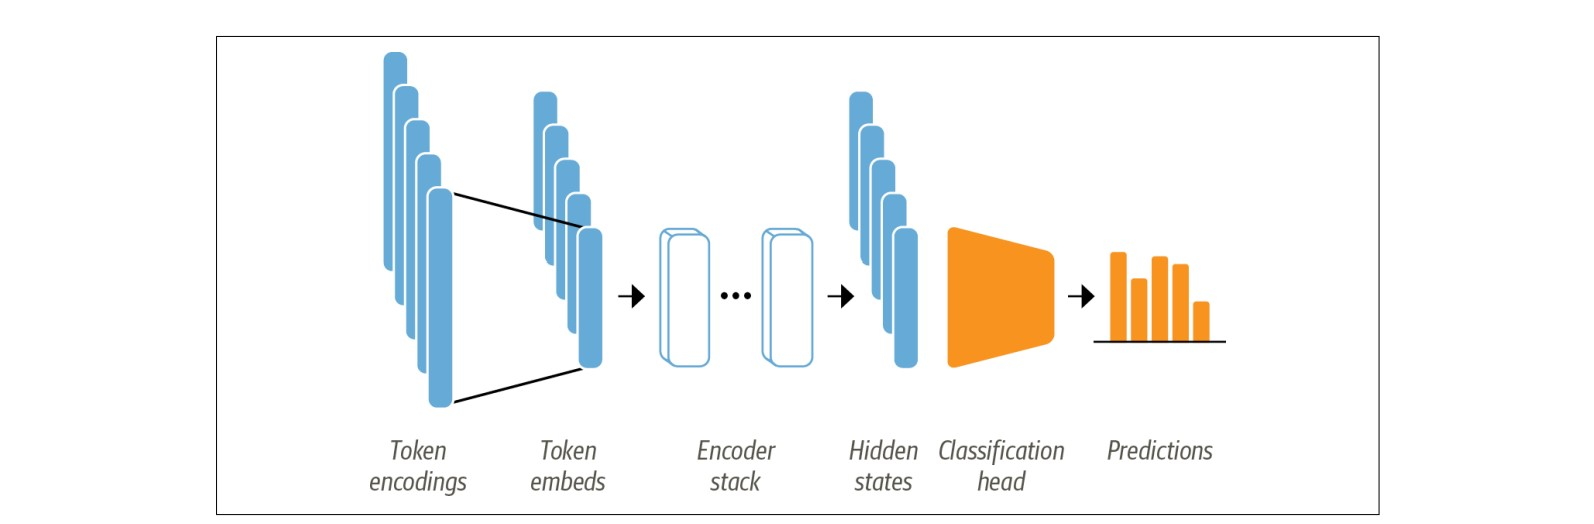

In [50]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [51]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-large-p2')

train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)

val_encodings = tokenizer(
    val_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [52]:
df.head(10)

,text,label
0,pagi2 udah di buat emosi :),0
1,"kok stabilitas negara, memange 10 thn negara t...",0
2,dah lah emosi mulu liat emyu,0
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0
4,dih lu yg nyebelin bego,0
5,"asli malu maluin org indo tolol yg rep latah ""...",0
6,drama abg tolol,0
7,masih emosi sih sama katla kemarin. mana keter...,0
8,"bangsat tribute no.1, bencana no.2 mau ngalahi...",0
9,pengen pergi jauh terus teriak sambil nangis s...,0


In [53]:
df.head()

,text,label
0,pagi2 udah di buat emosi :),0
1,"kok stabilitas negara, memange 10 thn negara t...",0
2,dah lah emosi mulu liat emyu,0
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",0
4,dih lu yg nyebelin bego,0


### Split Train Test Data

In [54]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5622,)
X_test shape: (1406,)
y_train shape: (5622,)
y_test shape: (1406,)


**FINE TUNING TRANSFORMERS**

### Modelling

In [56]:
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-large-p2')
model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p2', num_labels=6) 

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=256)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [57]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [58]:
class EmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

#
train_dataset = EmotionsDataset(train_encodings, y_train.tolist())
test_dataset = EmotionsDataset(test_encodings, y_test.tolist())

In [59]:
class WeightedBERT(AutoModelForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,
            **kwargs
        )
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits}


In [60]:
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "f1": f1}

In [61]:
from transformers import Trainer, TrainingArguments

In [62]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)


model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p2', num_labels=6)

In [63]:
from transformers import EarlyStoppingCallback, Trainer

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] 
)

trainer.train()

results = trainer.evaluate()
print(results)

/tmp/ipykernel_35/2562574761.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.724900,0.657809,0.764580,0.762830
2,0.585600,0.734444,0.754623,0.755992
3,0.317400,0.804050,0.785917,0.783053
4,0.139900,1.180137,0.766003,0.763606
5,0.044300,1.270869,0.775249,0.774735


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

{'eval_loss': 0.804049551486969, 'eval_accuracy': 0.7859174964438123, 'eval_f1': 0.7830534350227276, 'eval_runtime': 26.6051, 'eval_samples_per_second': 52.847, 'eval_steps_per_second': 3.308, 'epoch': 5.0}


In [65]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.804049551486969,
 'eval_accuracy': 0.7859174964438123,
 'eval_f1': 0.7830534350227276,
 'eval_runtime': 26.7703,
 'eval_samples_per_second': 52.521,
 'eval_steps_per_second': 3.287,
 'epoch': 5.0}

In [66]:
labels_list = ['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad']


In [67]:
outputs = trainer.predict(test_dataset)

print(outputs.metrics)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.804049551486969, 'test_accuracy': 0.7859174964438123, 'test_f1': 0.7830534350227276, 'test_runtime': 26.0756, 'test_samples_per_second': 53.92, 'test_steps_per_second': 3.375}


Accuracy: 0.7859
F1 Score: 0.7915


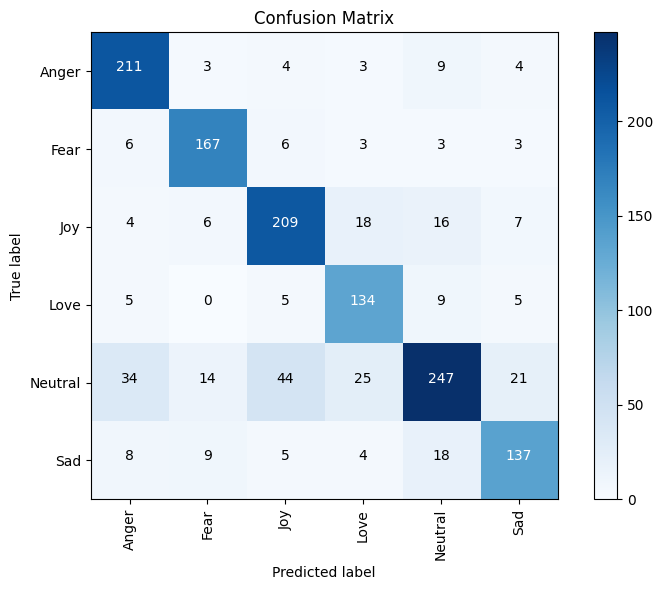


Classification report:

              precision    recall  f1-score   support

       Anger     0.7873    0.9017    0.8406       234
        Fear     0.8392    0.8883    0.8630       188
         Joy     0.7656    0.8038    0.7842       260
        Love     0.7166    0.8481    0.7768       158
     Neutral     0.8179    0.6416    0.7191       385
         Sad     0.7740    0.7569    0.7654       181

    accuracy                         0.7859      1406
   macro avg     0.7834    0.8067    0.7915      1406
weighted avg     0.7889    0.7859    0.7831      1406



In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

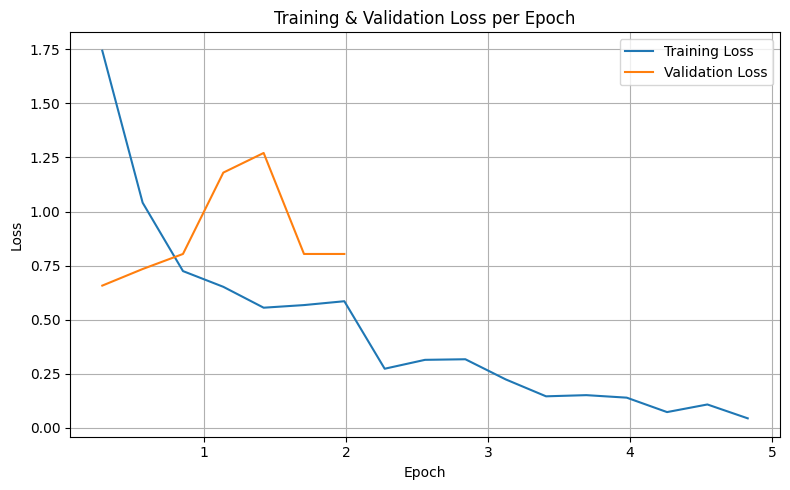

In [71]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    elif 'eval_loss' in log and 'epoch' in log:
        eval_loss.append(log['eval_loss'])

plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
